In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from sklearn.model_selection import train_test_split
from pathlib import Path
import torchvision
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
import helper
import cv2
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import pandas as pd 

### 5-Fold Cross validation module

In [2]:
path = '/home/e_radionova/cig5_Research_optimal_kernels/Dataset_parametrezation/experiment/new_simple_dataset_with_background'
jpg_imgs_folder = path + '/images_generation/dataset/images/'
jpg_imgs_names = np.sort(os.listdir(jpg_imgs_folder))
png_masks_folder = path + '/images_generation/dataset/masks/'
png_masks_names = np.sort(os.listdir(png_masks_folder))

In [3]:
def check_format_of_names_prints(checking_arr, format_name):
    print('\tCurrent len:', len(checking_arr))
    error_lst = []
    error_idxs = []
    for idx, name in enumerate(checking_arr):
        if format_name not in name:
            error_lst.append(name)
            error_idxs.append(idx) 

    print('\tNot suitable for format:',error_lst)
    checking_arr = np.delete(checking_arr, error_idxs)
    print('\tNew len:',len(checking_arr))
    return checking_arr

In [4]:
def check_format_of_names(checking_arr, format_name):
    error_lst = []
    error_idxs = []
    for idx, name in enumerate(checking_arr):
        if format_name not in name:
            error_lst.append(name)
            error_idxs.append(idx) 

    checking_arr = np.delete(checking_arr, error_idxs)
    return checking_arr

In [5]:
print('Train names:')
jpg_imgs_names = check_format_of_names_prints(jpg_imgs_names, '.jpg')
print('Val names:')
png_masks_names = check_format_of_names_prints(png_masks_names, '.png')

Train names:
	Current len: 406
	Not suitable for format: ['.ipynb_checkpoints']
	New len: 405
Val names:
	Current len: 406
	Not suitable for format: ['.ipynb_checkpoints']
	New len: 405


In [6]:
pd.DataFrame(jpg_imgs_names).to_csv('./imgs_names.csv', index=False)
pd.DataFrame(png_masks_names).to_csv('./masks_names.csv', index=False)

In [7]:
# data_masks_names = pd.read_csv('./masks_names.csv')  
# data_masks_names.head()

In [8]:
class_idxs = []
# 3 types of shape, 9 types of background
for i in range(3*9):
    for k in range(15):
        class_idxs.append(i)
class_idxs[:17]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]

In [9]:
K = 5
SEED = 123456
kf = StratifiedKFold(n_splits=K, random_state=SEED,shuffle=True)
kf.get_n_splits(jpg_imgs_names)

5

In [10]:
print(kf)

StratifiedKFold(n_splits=5, random_state=123456, shuffle=True)


In [11]:
dict_indices={}
i=0
for train_index, test_index in kf.split(jpg_imgs_names, class_idxs):
    dict_indices[i] = [train_index, test_index]
    i+=1
# dict_indices

### Dataloader

In [12]:
class MyDataset(Dataset):
    def __init__(self, images_folder, masks_folder, 
                 type_set, train_idxs, val_idxs,
                 img_transform=None, masks_transform=None):
        super(Dataset, self).__init__()
        
        self.images_folder = images_folder
        self.masks_folder = masks_folder

        images_names = np.sort(os.listdir(images_folder))
        images_names = check_format_of_names(images_names, '.jpg')
        masks_names = np.sort(os.listdir(masks_folder))
        masks_names = check_format_of_names(masks_names, '.png')
        
        if type_set == 'train':
            self.images_names = images_names[train_idxs]
            self.masks_names = masks_names[train_idxs]
        if type_set == 'val':
            self.images_names = images_names[val_idxs]
            self.masks_names = masks_names[val_idxs]
        
        self.img_transform = img_transform
        self.masks_transform = masks_transform

    def __len__(self):
        return len(self.images_names)
    
    def __getitem__(self, idx):
        item_image = Image.open(os.path.join(self.images_folder,
                                            self.images_names[idx])).convert('RGB')
        item_mask = Image.open(os.path.join(self.masks_folder,
                                              self.masks_names[idx])).convert('RGB')
        
        SEED = np.random.randint(123456789)
        if self.img_transform is not None:
            random.seed(SEED)
            item_image = self.img_transform(item_image)
        if self.masks_transform is not None:  
            random.seed(SEED)
            item_mask = self.masks_transform(item_mask)

        return item_image, item_mask

In [13]:
trans = transforms.Compose([
    transforms.Resize((288, 400)),
    transforms.ToTensor(),
])
# for i in range(K):
i=0
train_idxs = dict_indices[i][0]
val_idxs = dict_indices[i][1]

path = '/home/e_radionova/cig5_Research_optimal_kernels/Dataset_parametrezation/experiment/' + \
        'new_simple_dataset_with_background/images_generation/dataset'

train_set = MyDataset(images_folder = path + '/images', 
                      masks_folder = path + '/masks',
                      type_set = 'train', 
                      train_idxs = train_idxs, 
                      val_idxs = val_idxs,
                      img_transform = trans, masks_transform = trans)
val_set = MyDataset(images_folder = path + '/images', 
                    masks_folder = path + '/masks',
                    type_set = 'val', 
                    train_idxs = train_idxs, 
                    val_idxs = val_idxs,
                    img_transform = trans, masks_transform = trans)

In [14]:
image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size_train = 4
batch_size_val = 4

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size_train, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size_val, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 324, 'val': 81}

In [15]:
import torchvision.utils

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp

# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print('Image shape:', inputs.shape)
print('Mask shape:', masks.shape)
for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

Image shape: torch.Size([4, 3, 288, 400])
Mask shape: torch.Size([4, 3, 288, 400])
0.0 1.0 0.5489402 0.30576417
0.0 1.0 0.10437551 0.30507314


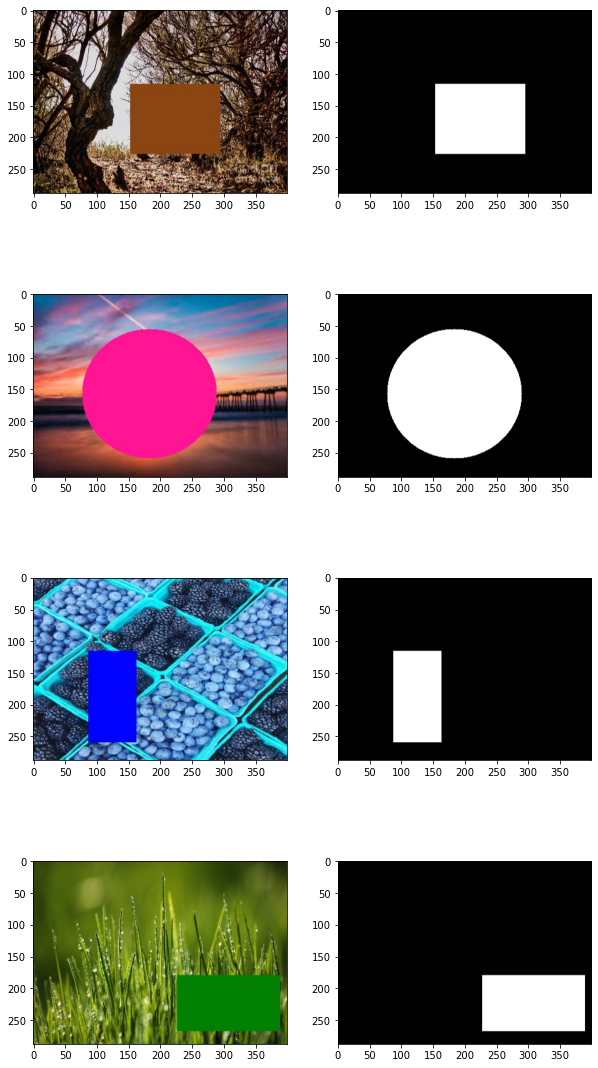

In [17]:
import torchvision.utils

n_pics_to_show = 4
inputs, masks = next(iter(dataloaders['train']))
fig, ax = plt.subplots(n_pics_to_show, 2, figsize=(10, 20))
for i in range(n_pics_to_show):
    pic, label = inputs[i], masks[i] 
    label_np = label.data.numpy().transpose(1, 2, 0) #[0]
    pic_np = pic.data.numpy().transpose(1, 2, 0) 
    ax[i,0].imshow(pic_np)
    ax[i,1].imshow(label_np)

### Training module

In [17]:
from torchsummary import summary
import torch
import torch.nn as nn
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from collections import defaultdict
import torch.nn.functional as F
from loss import dice_loss
from tqdm.notebook import tqdm

In [ ]:
def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += (1. - dice.data.cpu().numpy()) * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))  

In [18]:
def train_model(model, optimizer, scheduler, experiment_name, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    best_dice = 0
    
    writer = SummaryWriter(f'{logs_base_dir}/{experiment_name}')

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)    

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples   
            writer.add_scalar(f'Loss_{phase}', epoch_loss.item(), global_step=epoch)
            
            dice_epoch = metrics['dice'] / epoch_samples
            writer.add_scalar(f'DICE_{phase}', dice_epoch.item(), global_step=epoch)

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best loss")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            
            if phase == 'val' and dice_epoch > best_dice:
                print("saving best DICE")
                best_dice = dice_epoch

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))
    print('Best val DICE: {:4f}'.format(best_dice))
    
    file_name = "Best_DICE_" + Model_name + '_' + model_type 
    with open(f"{files_dir}/{file_name}.txt","a") as the_file:
            the_file.write('Fold №{}, best DICE: {}\n'.format(fold, best_dice))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [19]:
import warnings
warnings.filterwarnings('ignore')

### Please choose options

In [20]:
# Options of the size:
#     - 3
#     - 10
#     - 20
#     - 40
size_kernel = 10

# Options of the type:
#     - with_kernel
#     - usual
model_type = 'with_kernel'

# Options of the model:
#     - Unet
#     - Attention_Unet  
Model = 'Unet'

num_class = 3
Model_name = f'{Model}_{size_kernel}x{size_kernel}'

In [26]:
logs_base_dir = f'./logs_k-fold/{Model_name}_{model_type}'
os.makedirs(logs_base_dir, exist_ok=True)

files_dir = "Best_DICEs" 
os.makedirs(files_dir, exist_ok=True)

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Transform from plot to numpy

In [25]:
def get_img_from_fig(fig, dpi):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img

In [26]:
kernels_base_dir = './kernels_simple'
os.makedirs(kernels_base_dir, exist_ok=True)

kernels_subdir = f'./kernels_simple/kernel_simple_{size_kernel}x{size_kernel}'
os.makedirs(kernels_subdir, exist_ok=True)

### K-fold training

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from pyefd import elliptic_fourier_descriptors
from pyEFD import plot_efd

import io
import cv2
import numpy as np
import matplotlib.pyplot as plt

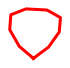

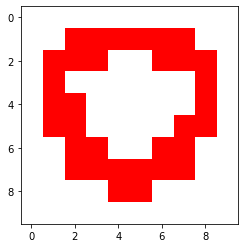

Unique:  [0. 1.]
Unique after normalization:  [-1.88293774  0.531085  ]


Epoch 0/29
----------
LR 0.001



train: bce: 0.444392, dice: 0.150052, loss: 0.647170



val: bce: 0.363217, dice: 0.123342, loss: 0.619937
saving best loss
saving best DICE
0m 38s
Epoch 1/29
----------
LR 0.001


In [ ]:
file_name = "Best_DICE_" + Model_name + '_' + model_type 
exp_name = datetime.now().isoformat(timespec='minutes') + '_' + Model_name + '_' + model_type
with open(f"{files_dir}/{file_name}.txt","a") as the_file:
        the_file.write('\nExperiment: {}\n'.format(exp_name))
            
            
for fold in range(K):
    train_idxs = dict_indices[fold][0]
    val_idxs = dict_indices[fold][1]

    path = '/home/e_radionova/cig5_Research_optimal_kernels/Dataset_parametrezation/experiment/' + \
            'new_simple_dataset_with_background/images_generation/dataset'

    train_set = MyDataset(images_folder = path + '/images', 
                          masks_folder = path + '/masks',
                          type_set = 'train', 
                          train_idxs = train_idxs, 
                          val_idxs = val_idxs,
                          img_transform = trans, masks_transform = trans)
    val_set = MyDataset(images_folder = path + '/images', 
                        masks_folder = path + '/masks',
                        type_set = 'val', 
                        train_idxs = train_idxs, 
                        val_idxs = val_idxs,
                        img_transform = trans, masks_transform = trans)
    
    ############################################################
    if model_type == 'with_kernel':
        png_masks_folder = path + '/masks/'
        png_masks_names = train_set.masks_names

        # Find contours for circle

        order_param = 10
        contours_dict_jpg = {}
        contours_dict_jpg = dict.fromkeys(png_masks_names)

        for mask in contours_dict_jpg.keys():
            img = cv2.imread(png_masks_folder + mask)
            imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ret,thresh = cv2.threshold(imgray, 127, 255, 0)
            contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            contours_new = np.vstack(contours).squeeze()
            order = order_param
            coeffs = elliptic_fourier_descriptors(contours_new, order=order)
            contours_dict_jpg[mask] = coeffs

        sum_contours = 0
        sum_index = 0
        for i, cont in enumerate(list(contours_dict_jpg.values())):
            sum_contours += cont
            sum_index += i

        coeffs_mean = sum_contours / sum_index

        locus = (0.0, 0.0)
        m=10
        xt = np.ones((m,)) * locus[0]
        yt = np.ones((m,)) * locus[1]

        t = np.linspace(0, 1.0, m)

        for n in range(coeffs_mean.shape[0]):
            xt += (coeffs_mean[n, 0] * np.cos(2 * (n + 1) * np.pi * t)) + (
                coeffs_mean[n, 1] * np.sin(2 * (n + 1) * np.pi * t)
            )
            yt += (coeffs_mean[n, 2] * np.cos(2 * (n + 1) * np.pi * t)) + (
                coeffs_mean[n, 3] * np.sin(2 * (n + 1) * np.pi * t)
            )

        fig = plt.figure(figsize=(1, 1))
        ax = fig.add_subplot(111)
        ax.plot(xt, yt, 'r', linewidth=3)
        ax.axis('off')
        plt.show()

        plot_img_np = get_img_from_fig(fig, dpi=size_kernel)
        plt.imshow(plot_img_np)
        plt.show()
        plot_img_np = plot_img_np.transpose(2,0,1)
        plot_img_np = plot_img_np / 255
        print('Unique: ',np.unique(plot_img_np))

        plot_img_np = (plot_img_np - np.mean(plot_img_np)) / np.std(plot_img_np)
        print('Unique after normalization: ', np.unique(plot_img_np))



        if model_type == 'with_kernel':
            with open(f'./kernels_simple/kernel_simple_{size_kernel}x{size_kernel}/kernel_{size_kernel}x{size_kernel}_fold#_{fold}.npy', 'wb') as f:
                np.save(f, plot_img_np)   
    ############################################################

    if size_kernel == 3:
        import unet_3x3
        model = unet_3x3.UNet(num_class).to(device)
    elif size_kernel == 10:
        import unet_10x10
        model = unet_10x10.UNet(num_class).to(device)
    elif size_kernel == 15:
        import unet_15x15
        model = unet_15x15.UNet(num_class).to(device)    
    elif size_kernel == 20:
        import unet_20x20
        model = unet_20x20.UNet(num_class).to(device) 
    elif size_kernel == 40:
        import unet_40x40
        model = unet_40x40.UNet(num_class).to(device) 
    else:
        print('Such model is not defined')
    
    optimizer_ft = optim.Adam(model.parameters(), lr=1e-3)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=15, gamma=0.1)
    
    exp_name = datetime.now().isoformat(timespec='minutes') + '_' + Model_name + '_' + model_type +'_fold_#' + str(fold)
    
    ######### Kernel initialization #########
    if model_type == 'with_kernel':
        shape_k = model._modules['dconv_down1'][0].weight.data.shape
        kernel = torch.zeros_like(torch.rand(shape_k))
        kernel_new = torch.from_numpy(np.load(f'./kernels_simple/kernel_simple_{size_kernel}x{size_kernel}/kernel_{size_kernel}x{size_kernel}_fold#_{fold}.npy'))

        for i in range(kernel.shape[0]):
            for j in range(kernel.shape[1]):
                kernel[i][j] = kernel_new[1]
        model._modules['dconv_down1'][0].weight.data = kernel
        model._modules['dconv_down1'][0].weight.data = model._modules['dconv_down1'][0].weight.data.to(device)

    model = train_model(model, optimizer_ft, exp_lr_scheduler, experiment_name=exp_name, num_epochs=30) 

### Show kernel after training

In [ ]:
model._modules['dconv_down1'][0].weight.data

In [ ]:
optimized_kernel = model._modules['dconv_down1'][0].weight.data
optimized_kernel.shape

In [ ]:
plt.imshow(optimized_kernel.cpu().numpy()[0].transpose(1,2,0))

### DICE mean and std

In [ ]:
with open(f'{files_dir}/{file_name}.txt') as f:
    lines = f.readlines()

In [ ]:
new_lines = [line for line in lines if 'DICE' in line]
new_lines

In [ ]:
dices = np.array([float(new_lines[i].split()[4]) for i in range(len(new_lines))])

In [ ]:
mean_dice = np.mean(dices)
std_dice = np.std(dices)
print('DICE = {}+-{}'.format(round(mean_dice, 3), round(std_dice,3)))

In [ ]:
with open(f"{files_dir}/{file_name}.txt","a") as the_file:
    the_file.write('DICE = {}+-{}\n'.format(round(mean_dice, 3), round(std_dice,3)))

### See results

In [144]:
Model = 'Unet'
model_type = 'with_kernel'

In [145]:
files_dir = "Best_DICEs"
file_name = "Best_DICE_" + Model_name + '_' + model_type 

In [146]:
with open(f'{files_dir}/{file_name}.txt') as f:
    lines = f.readlines()

In [148]:
kernel_lst = [3, 10, 20, 40]
type_lst = ['with_kernel', 'usual']

In [150]:
dict_dices = {}
for size_kernel in kernel_lst:
    for model_type in type_lst:
        Model_name = f'{Model}_{size_kernel}x{size_kernel}'
        file_name = "Best_DICE_" + Model_name + '_' + model_type 
        with open(f'{files_dir}/{file_name}.txt') as f:
            lines = f.readlines()
            if model_type == 'usual':
                print('{}: \t\t{}'.format(file_name, lines[-1].split()[-1]))
            else:
                print('{}: \t{}'.format(file_name, lines[-1].split()[-1]))
            dict_dices[file_name] = lines[-1].split()[-1]

Best_DICE_Unet_3x3_with_kernel: 	0.948+-0.014
Best_DICE_Unet_3x3_usual: 		0.985+-0.004
Best_DICE_Unet_10x10_with_kernel: 	0.952+-0.005
Best_DICE_Unet_10x10_usual: 		0.928+-0.027
Best_DICE_Unet_20x20_with_kernel: 	0.941+-0.013
Best_DICE_Unet_20x20_usual: 		0.778+-0.072
Best_DICE_Unet_40x40_with_kernel: 	0.848+-0.02
Best_DICE_Unet_40x40_usual: 		0.632+-0.138


In [151]:
import re
# re.findall(r'\d+', 'Best_DICE_Unet_10x10_with_kernel')

In [152]:
ff = 'Best_DICE_Unet_10x10_usual'
ff.split('_')

['Best', 'DICE', 'Unet', '10x10', 'usual']

In [159]:
kernel_sizes = []
kenrel_types = []
dice_values = []
dice_stds = []
for key in dict_dices.keys():
    kernel_size = re.findall(r'\d+', key)[0]
    type_k = key.split('_')[-1]
    if type_k == 'usual':
        type_kernel = 'usual'
    else:
        type_kernel = 'with_kernel'
    dice = float(dict_dices[key].split('+-')[0])
    dice_std = float(dict_dices[key].split('+-')[1])
    kernel_sizes.append(int(kernel_size))
    kenrel_types.append(type_kernel)
    dice_values.append(dice)
    dice_stds.append(dice_std)

In [160]:
print(kernel_sizes)
print(kenrel_types)
print(dice_values)
print(dice_stds)

[3, 3, 10, 10, 20, 20, 40, 40]
['with_kernel', 'usual', 'with_kernel', 'usual', 'with_kernel', 'usual', 'with_kernel', 'usual']
[0.948, 0.985, 0.952, 0.928, 0.941, 0.778, 0.848, 0.632]
[0.014, 0.004, 0.005, 0.027, 0.013, 0.072, 0.02, 0.138]


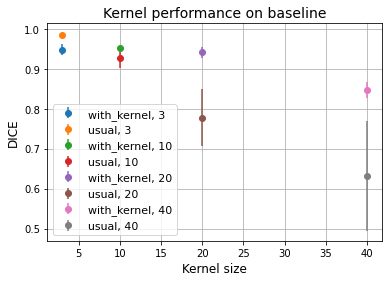

In [172]:
for i, x in enumerate(kenrel_types):
#     plt.scatter(kernel_sizes[i], dice_values[i], label = str(x) + ', ' + str(kernel_sizes[i]), linewidths=4)
    plt.errorbar(kernel_sizes[i], dice_values[i], dice_stds[i], 
                 label = str(x) + ', ' + str(kernel_sizes[i]), fmt='o')
plt.legend(loc='lower left', fontsize=11)
plt.title('Kernel performance on baseline', fontsize=14)
plt.xlabel('Kernel size', fontsize=12)
plt.ylabel('DICE', fontsize=12)
plt.grid(True)
plt.show()